# HyDE

https://ar5iv.labs.arxiv.org/html/2212.10496

In [36]:
from datasets import load_dataset
import pandas as pd
import torch

dataset = load_dataset("msaad02/categorized-data", split="train")
df = dataset.to_pandas()

train_df = df.groupby("category").sample(n=100, replace=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=True, min_df=5)

train_vect = vectorizer.fit_transform(train_df['data'])

In [39]:
text_to_int = {text: idx for idx, text in enumerate(train_df['category'].unique())}
int_to_text = {idx: text for text, idx in text_to_int.items()}

train_df['category_vect'] = train_df['category'].apply(lambda x: text_to_int[x])

In [40]:
# to run at inference time
# vectorizer.transform(["some text"])

In [78]:
train_proportion = 0.8
validation_prop = 0.1
train_size = int(train_proportion * train_vect.shape[0])
validation_size = int(validation_prop * train_vect.shape[0])

X_train = torch.tensor(train_vect[:train_size].toarray(), dtype=torch.float32)
y_train = torch.tensor(train_df['category_vect'][:train_size].to_numpy(), dtype=torch.long)
X_val = torch.tensor(train_vect[train_size:train_size+validation_size].toarray(), dtype=torch.float32)
y_val = torch.tensor(train_df['category_vect'][train_size:train_size+validation_size].to_numpy(), dtype=torch.long)
X_test = torch.tensor(train_vect[train_size+validation_size:].toarray(), dtype=torch.float32)
y_test = torch.tensor(train_df['category_vect'][train_size+validation_size:].to_numpy(), dtype=torch.long)

In [57]:
X_train.shape

torch.Size([960, 5612])

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
# Hyper-parameters
input_size = 5612
hidden_size = 5000
num_classes = df['category'].unique().__len__()
num_epochs = 150

# Instantiate the model, optimizer, and loss function
model = SimpleNN(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses = []
validation_losses = []

# Train the model
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Validation loss
    validation_loss = criterion(model(X_val), y_val)

    train_losses.append(loss.detach().numpy())
    validation_losses.append(validation_loss.detach().numpy())

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # if (epoch+1) % 0 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {validation_loss.item():.4f}')
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/150], Loss: 2.5995, Validation Loss: 2.6363
Epoch [2/150], Loss: 2.3284, Validation Loss: 2.3806
Epoch [3/150], Loss: 2.1296, Validation Loss: 2.1810
Epoch [4/150], Loss: 1.9634, Validation Loss: 2.0217
Epoch [5/150], Loss: 1.8190, Validation Loss: 1.8940
Epoch [6/150], Loss: 1.6920, Validation Loss: 1.7853
Epoch [7/150], Loss: 1.5795, Validation Loss: 1.6896
Epoch [8/150], Loss: 1.4785, Validation Loss: 1.6037
Epoch [9/150], Loss: 1.3868, Validation Loss: 1.5259
Epoch [10/150], Loss: 1.3028, Validation Loss: 1.4546
Epoch [11/150], Loss: 1.2253, Validation Loss: 1.3892
Epoch [12/150], Loss: 1.1536, Validation Loss: 1.3289
Epoch [13/150], Loss: 1.0869, Validation Loss: 1.2731
Epoch [14/150], Loss: 1.0247, Validation Loss: 1.2211
Epoch [15/150], Loss: 0.9663, Validation Loss: 1.1726
Epoch [16/150], Loss: 0.9116, Validation Loss: 1.1271
Epoch [17/150], Loss: 0.8601, Validation Loss: 1.0843
Epoch [18/150], Loss: 0.8116, Validation Loss: 1.0439
Epoch [19/150], Loss: 0.7658, Validat

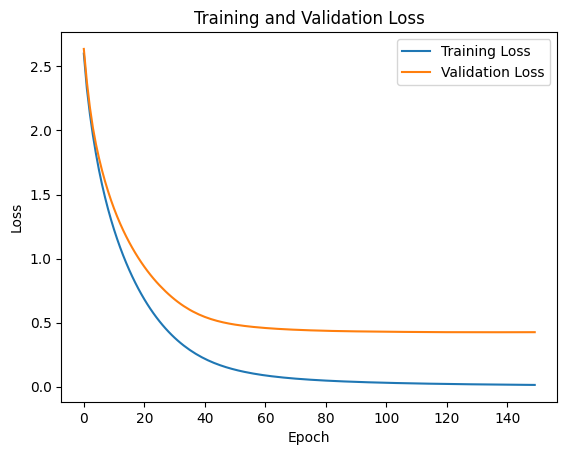

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the training and validation loss
plt.plot(np.array(train_losses), label='Training Loss')
plt.plot(np.array(validation_losses), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [97]:
# Find the paramter count of the model
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

28,130,013 total parameters.


In [98]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluate the model on the test data
with torch.no_grad():
    model.eval()
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, predicted)
print("Confusion Matrix:")
print(confusion_mat)


Accuracy: 91.67%
Confusion Matrix:
[[ 7  0  0  1  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0  0  0]
 [ 1  0  2  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 12  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  1  0  0  0 13]]


In [125]:
# Try it on my own text
text = "Class projects and trade case simulations will enhance your analytical skills through real world applications. Hear from industry professionals in the classroom and take advantage of our skilled staff to earn internships in the field."
text_vect = vectorizer.transform([text])
text_vect = torch.tensor(text_vect.toarray(), dtype=torch.float32)

with torch.no_grad():
    model.eval()
    outputs = model(text_vect)
    _, predicted = torch.max(outputs.data, 1)

int_to_text[predicted.detach().numpy()[0]]

'academics'

## Next to-do

Need to change the input data to the questions being stored instead of running this on the data itself.